In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [2]:
import numpy as np

import ujson
import attr
import random
import torch

from glob import glob
from tqdm import tqdm_notebook
from itertools import islice
from boltons.iterutils import pairwise, chunked_iter
from collections import Counter

from gensim.models import KeyedVectors

from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import functional as F

In [3]:
vectors = KeyedVectors.load_word2vec_format(
    '../data/vectors/GoogleNews-vectors-negative300.bin.gz',
    binary=True,
)

In [205]:
class Corpus:
    
    def __init__(self, pattern, skim=None):
        self.pattern = pattern
        self.skim = skim
        
    def lines(self):
        for path in glob(self.pattern):
            with open(path) as fh:
                for line in fh:
                    yield line.strip()

    def abstracts(self):
        lines = self.lines()
        if self.skim:
            lines = islice(lines, self.skim)
        for line in tqdm_notebook(lines, total=self.skim):
            raw = ujson.loads(line)
            yield Abstract.from_raw(raw)

In [206]:
@attr.s
class Abstract:
    
    sentences = attr.ib()
    
    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])
            
    def xy(self):
        for i, sent in enumerate(self.sentences):
            x = sent.tensor()
            y = i / (len(self.sentences)-1)
            y = torch.FloatTensor([y])
            yield x, y

In [220]:
@attr.s
class Sentence:
    
    tokens = attr.ib()
    
    def tensor(self, dim=300, pad=50):
        x = [vectors[t] for t in self.tokens if t in vectors]
        x += [np.zeros(dim)] * pad
        x = x[:pad]
        x = list(reversed(x))
        x = np.array(x)
        x = torch.from_numpy(x)
        x = x.float()
        return x

In [221]:
class SentenceEncoder(nn.Module):
    
    def __init__(self, embed_dim=300, lstm_dim=128):
        super().__init__()
        self.lstm_dim = lstm_dim
        self.lstm = nn.LSTM(embed_dim, lstm_dim, batch_first=True)
        
    def forward(self, tokens):
        h0 = Variable(torch.zeros(1, len(tokens), self.lstm_dim))
        c0 = Variable(torch.zeros(1, len(tokens), self.lstm_dim))
        _, (hn, cn) = self.lstm(sents, (h0, c0))
        return hn

In [222]:
class AbstractEncoder(nn.Module):
    
    def __init__(self, embed_dim=128, lstm_dim=128):
        super().__init__()
        self.lstm_dim = lstm_dim
        self.lstm = nn.LSTM(embed_dim, lstm_dim, batch_first=True)
        
    def forward(self, sents):
        h0 = Variable(torch.zeros(1, len(sents), self.lstm_dim))
        c0 = Variable(torch.zeros(1, len(sents), self.lstm_dim))
        _, (hn, cn) = self.lstm(sents, (h0, c0))
        return hn

In [240]:
class Regressor(nn.Module):
    
    def __init__(self, sent_dim=128*2, lin_dim=128):
        super().__init__()
        self.lin1 = nn.Linear(sent_dim, lin_dim)
        self.lin2 = nn.Linear(lin_dim, lin_dim)
        self.lin3 = nn.Linear(lin_dim, lin_dim)
        self.out = nn.Linear(lin_dim, 1)
        
    def forward(self, x):
        y = F.relu(self.lin1(x))
        y = F.relu(self.lin2(y))
        y = F.relu(self.lin3(y))
        y = self.out(y)
        return y

In [241]:
train = Corpus('../data/train.json/*.json', 100)

In [242]:
torch.manual_seed(1)

In [243]:
sentence_encoder = SentenceEncoder()

In [244]:
abstract_encoder = AbstractEncoder()

In [245]:
regressor = Regressor()

In [246]:
criterion = nn.MSELoss()

In [247]:
optimizer = torch.optim.Adam(regressor.parameters(), lr=1e-3)

In [248]:
train_loss = []
for epoch in range(30):

    epoch_loss = 0
    for ab in train.abstracts():

        sentence_encoder.zero_grad()
        abstract_encoder.zero_grad()
        regressor.zero_grad()

        # Shuffle sentences.
        xy = list(ab.xy())
        random.shuffle(xy)
        x, y = zip(*xy)

        # Encode sentences.
        tokens = Variable(torch.stack(x))
        sents = sent_encoder(tokens)

        # Encode (shuffled) context.
        context = abs_encoder(sents)

        sents = sents.view(len(x), -1)
        context = context.view(-1)

        for sent, offset in zip(sents, y):

            offset = Variable(offset)

            y_pred = regressor(torch.cat([context, sent]))

            loss = criterion(y_pred, offset)
            loss.backward(retain_graph=True)

            optimizer.step()

            epoch_loss += loss.data[0]
        
    train_loss.append(epoch_loss)
    print(f'Epoch {epoch}')
    print(epoch_loss)

HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 0
75.2459415496512


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 1
70.0954111708565


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 2
68.61610391533465


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 3
67.95817014765663


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 4
67.1936248975951


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 5
63.640084077658


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 6
64.55972161050161


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 7
60.61041126280634


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 8
60.78207471488673


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 9
60.6047559511444


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 10
61.73420262994445


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 11
60.05766356426608


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 12
56.6648662011533


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 13
56.37561322242779


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 14
55.52293811701941


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 15
56.837276854407264


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 16
54.03641417786048


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 17
55.53314437526569


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 18
52.559403225831616


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 19
51.86943633555469


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 20
53.26303827988423


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 21
52.813840928650635


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 22
50.989047088738744


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 23
50.55778571738347


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 24
48.78264276376149


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 25
49.14179712925331


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 26
50.34679909849396


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 27
47.99819371483272


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 28
48.002038236219505


HBox(children=(IntProgress(value=0), HTML(value='')))


Epoch 29
51.14198322271457


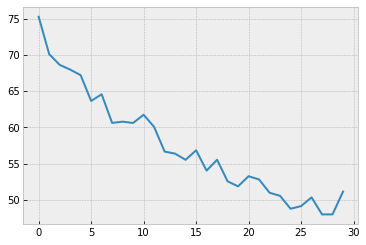

In [249]:
plt.plot(train_loss)